<a href="https://colab.research.google.com/github/TulioChiodi/HRTF_individualization-/blob/python-code/model_ear_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Using TensorBoard

In [0]:
# !wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
# !unzip ngrok-stable-linux-amd64.zip

--2020-03-16 09:01:31--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 52.20.185.228, 34.196.154.11, 52.87.72.17, ...
Connecting to bin.equinox.io (bin.equinox.io)|52.20.185.228|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13773305 (13M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip’

ngrok-stable-linux- 100%[===================>]  13.13M  25.6MB/s    in 0.5s    

2020-03-16 09:01:32 (25.6 MB/s) - ‘ngrok-stable-linux-amd64.zip’ saved [13773305/13773305]

Archive:  ngrok-stable-linux-amd64.zip
  inflating: ngrok                   


In [0]:
# import os
# LOG_DIR = 'runs'
# os.makedirs(LOG_DIR, exist_ok=True)
# get_ipython().system_raw(
#     'tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'
#     .format(LOG_DIR))

In [0]:
# get_ipython().system_raw('./ngrok http 6006 &')

In [0]:
# ! curl -s http://localhost:4040/api/tunnels | python3 -c \
#     "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

http://93334829.ngrok.io


## Declaring variables:

In [0]:
from torch.utils.tensorboard import SummaryWriter
# load data from loader
images, labels = next(iter(train_dataloader))

images = images.to('cuda')
labels = labels.to('cuda')

tb = SummaryWriter()
tb.add_images("Image", images)
tb.add_graph(net, images)
for i in range(1, 20):
    tb.add_scalar("Tag", 10/i, i)
    
tb.close()

In [0]:
from __future__ import print_function, division
from pathlib import Path
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, utils
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from IPython.core.debugger import set_trace
import cv2
from PIL import Image
import random

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

plt.ion()   # interactive mode

path = Path('drive/My Drive/Colab/Ear_Project')
if not os.path.exists('./dataset'):
   os.chdir(path)

#reproducibility

random.seed(420)
torch.manual_seed(420)
torch.cuda.manual_seed(420)
np.random.seed(420)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [0]:
class AutoCanny():
  def __call__(self,sample):
    img, label = sample['image'], sample['label']
    img = np.asarray(img)
    img = cv2.bilateralFilter(img, 4, 70, 110)
    img = auto_canny(img)

    return {'image': img.astype(np.float32) ,'label': label}

class Padding():
  def __call__(self,sample):
    img, label = sample['image'], sample['label']
    w, h = img.size[:2]
    pad_width, pad_height = (max(0,h-w), max(0,w-h))

    if pad_width % 2 == 0:
      pad_right = pad_left = int(pad_width/2)
    else:
      pad_right = int(pad_width/2)
      pad_left = int(pad_width/2) + 1

    if pad_height % 2 == 0:
      pad_top = pad_bottom = int(pad_height/2)
    else:
      pad_top = int(pad_height/2)
      pad_bottom = int(pad_height/2) + 1

    img = transforms.functional.pad(img, padding=(pad_left, pad_top, pad_right, pad_bottom))
    

    return {'image': img, 'label': label}

class Resize():
  def __call__(self, sample):
    img, label = sample['image'], sample['label']
    img = transforms.functional.resize(img, 96)
    # set_trace()
    # img = np.asarray(img)
    # img = cv2.resize(img,(96,96),interpolation = cv2.INTER_AREA)
    return {'image': img, 'label': label}

class ToTensor(object):
  """Convert ndarrays in sample to Tensors."""

  def __call__(self, sample):
      img, label = (sample['image'], sample['label'])      
      # swap color axis because
      # numpy image: H x W x C
      # torch image: C X H X W
      img = img.reshape(96,96,1)
      img = img.transpose((2, 0, 1))
      return {'image': torch.from_numpy(img), 'label': torch.from_numpy(label)}

class Normalize():
  def __init__(self, mean, std, inplace=False):
    self.mean = mean
    self.std = std
    self.inplace = inplace

  def __call__(self, sample):
    img, label = sample['image'], sample['label']

    return transforms.functional.normalize(img, self.mean, self.std, self.inplace), label


def auto_canny(image, sigma=0.6):
	v = np.median(image)
	lower = int(max(0, (1.0 - sigma) * v))
	upper = int(min(255, (1.0 + sigma) * v))
	edged = cv2.Canny(image, lower, upper)

	return edged
  #edged.astype(np.float32)


def show_batch(batch):
  images_batch, label = batch

  grid = utils.make_grid(images_batch)
  for img in images_batch:
    print (img.shape)
    # print(f'Min pixel value: {min(img)},\nMax pixel value: {max(img)}')
  plt.imshow(grid.numpy().transpose(1,2,0))



In [0]:
class CNNNet(nn.Module):
  def __init__(self):
    super(CNNNet, self).__init__()
    self.features = nn.Sequential(
      nn.Conv2d(1, 16, 3, padding=1),
      nn.BatchNorm2d(16),
      nn.ReLU(),
      nn.MaxPool2d(2, 2),
      nn.Conv2d(16, 16, kernel_size=3, padding=1),
      nn.BatchNorm2d(16),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2, stride=2),
    )
    self.classifier = nn.Sequential(
      nn.Linear(16*24*24, 1000),
      nn.Linear(1000, 100),
      nn.Linear(100, 8),
    )
  def forward(self, x):
    x = self.features(x)
    x = torch.flatten(x, 1)
    x = self.classifier(x)
    return x

net = CNNNet().cuda()

In [0]:
def standard(img):
  return (img - np.mean(img)) / np.std(img)

class EarDataset(Dataset):

  def __init__(self, pkl_file, root_dir, transform=None):
    self.dataset = pd.read_pickle(pkl_file)
    self.root_dir = root_dir
    self.transform = transform
      
  def __len__(self):
    return len(self.dataset)


  def __getitem__(self, idx):
    if torch.is_tensor(idx):
      idx = idx.tolist()
    
    img_name = os.path.join(self.root_dir, self.dataset.iloc[idx, 0])
    image = Image.open(img_name)
    image = image.convert('L')
    label = self.dataset.iloc[idx,1].astype(np.float32)
    sample = {'image': image, 'label': label}


    if self.transform:
      sample = self.transform(sample)
    return sample


class DatasetFromSubset(Dataset):
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform

    def __getitem__(self, index):
        img, label = self.subset[index]
        if self.transform:
            img, label = self.transform((img, label))
        return img, label

    def __len__(self):
        return len(self.subset)

In [0]:
transform = transforms.Compose([Padding(),
                                Resize(),
                                AutoCanny(),
                                ToTensor(),
                                Normalize([0],[255]),
                                ])

pkl_file = 'dataset109.pkl'

root_dir_canny = 'dataset'
root_dir_original = 'dataset_original/dataset'

init_dataset = EarDataset(pkl_file=pkl_file, root_dir=root_dir_original, transform=transform)

lengths = [87, 22]

train_subset, test_subset = random_split(init_dataset, lengths)

train_dataset = DatasetFromSubset(train_subset, transform=None)
test_dataset = DatasetFromSubset(test_subset, transform=None)

train_dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=2)

Min pixel value: 0.0,
Max pixel value: 1.0,
Type torch.FloatTensor,
Shape torch.Size([1, 96, 96])
Min pixel value: 0.0,
Max pixel value: 1.0,
Type torch.FloatTensor,
Shape torch.Size([1, 96, 96])


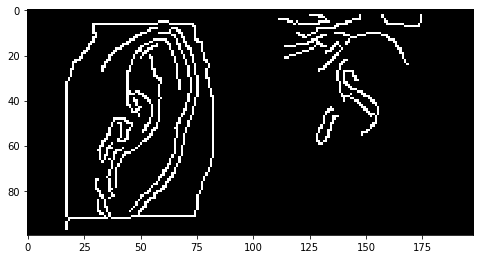

In [0]:
def show_batch(batch):
  images_batch, label = batch

  grid = utils.make_grid(images_batch)
  for img in images_batch:
    print(f'Min pixel value: {torch.min(img)},\nMax pixel value: {torch.max(img)},\nType {img.type()},\nShape {img.shape}')
  plt.figure(figsize=(8,8))
  plt.imshow(grid.numpy().transpose(1,2,0))

batch = next(iter(train_dataloader))
show_batch(batch)

Min pixel value: 0.0,
Max pixel value: 1.0,
Type torch.FloatTensor,
Shape torch.Size([1, 96, 96])
Min pixel value: 0.0,
Max pixel value: 1.0,
Type torch.FloatTensor,
Shape torch.Size([1, 96, 96])


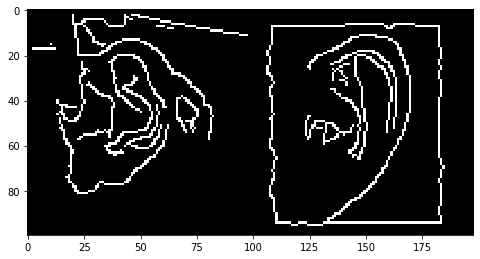

In [0]:
batch = next(iter(test_dataloader))
show_batch(batch)

In [0]:
def weight_reset(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        m.reset_parameters()


def train(model, optimizer, loss_fn, train_loader, val_loader, epochs=20, device="cpu"):
  model.apply(weight_reset)
  for epoch in range(epochs):
    training_loss = 0.0
    valid_loss = 0.0
    model.train()
    for batch in train_loader:
      optimizer.zero_grad()
      inputs, target = batch
      inputs = inputs.to(device)
      target = target.to(device)
      output = model(inputs)
      loss = loss_fn(output, target)
      loss.backward()
      optimizer.step()
      training_loss += loss.item()
      train_error = torch.dist(target, output)
    training_loss /= len(train_loader)

    model.eval()
    num_correct = 0
    num_examples = 0
    for batch in val_loader:
      inputs, targets = batch
      inputs = inputs.to(device)
      output = model(inputs)
      targets = targets.to(device)
      loss = loss_fn(output,targets)
      valid_loss += loss.item()
      val_error = torch.dist(targets, output)
    valid_loss /= len(val_loader)

    print(f'Epoch: {epoch}, Training Loss: {training_loss}, Validation Loss: {valid_loss}, Train Error = {train_error}, Validation Error = {val_error}')


In [0]:
import torch.optim as optim
criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=0.00005)

train(model=net, optimizer=optimizer, loss_fn=criterion,
      train_loader=train_dataloader, val_loader=test_dataloader,
      epochs=50, device="cuda")


Epoch: 0, Training Loss: 0.8305598436431452, Validation Loss: 0.4518359032544223, Train Error = 1.5245875120162964, Validation Error = 3.5352344512939453
Epoch: 1, Training Loss: 0.2159890246323564, Validation Loss: 0.18529139120470395, Train Error = 1.4242100715637207, Validation Error = 2.418330430984497
Epoch: 2, Training Loss: 0.1463178095661781, Validation Loss: 0.1507841551845724, Train Error = 0.6185665130615234, Validation Error = 2.429399251937866
Epoch: 3, Training Loss: 0.09773813890801235, Validation Loss: 0.1240162348205393, Train Error = 0.9620844125747681, Validation Error = 1.94253671169281
Epoch: 4, Training Loss: 0.07187313683839007, Validation Loss: 0.1581606458533894, Train Error = 0.6561749577522278, Validation Error = 1.805037498474121
Epoch: 5, Training Loss: 0.06662501987408508, Validation Loss: 0.16358727758580988, Train Error = 0.7979961037635803, Validation Error = 1.8227052688598633
Epoch: 6, Training Loss: 0.06805482165972618, Validation Loss: 0.15672275694

Epoch: 99, Training Loss: 0.00010694790489651496, Validation Loss: 0.0673814918845892, pnorm = 1.5491362810134888

Epoch: 99, Training Loss: 0.00013848422713635955, Validation Loss: 0.09261073172092438, pnorm = 1.6659570932388306

In [0]:
path = 'testset/0051_left.jpg'
target = torch.tensor([1.7321, 0.82316, 1.7177, 1.3736, 5.94, 2.8194, 0.57672, 1.0697]).to('cuda')
image = Image.open(path)
sample_pred = {'image': image, 'label': np.random.randn(8)}
transformed_sample = transform(sample_pred)
print_img = transformed_sample[0]
img = transformed_sample[0].unsqueeze(0).to('cuda')
print(torch.max(img))
prediction = net(img)
error = torch.dist(target, prediction)
print(f'prediction: {prediction}.\nGround truth: {target}.')
print(error)

tensor(1., device='cuda:0')
prediction: tensor([[1.9674, 0.6240, 1.6416, 1.6418, 6.3555, 3.0549, 0.6028, 1.1557]],
       device='cuda:0', grad_fn=<AddmmBackward>).
Ground truth: tensor([1.7321, 0.8232, 1.7177, 1.3736, 5.9400, 2.8194, 0.5767, 1.0697],
       device='cuda:0').
tensor(0.6394, device='cuda:0', grad_fn=<DistBackward>)


In [0]:
erro = abs(target-prediction)
erro

tensor([[0.2353, 0.1991, 0.0761, 0.2682, 0.4155, 0.2355, 0.0261, 0.0860]],
       device='cuda:0', grad_fn=<AbsBackward>)

In [0]:
erro.sum()

tensor(1.5418, device='cuda:0', grad_fn=<SumBackward0>)


Previsão: 1.8504, 0.4400, 1.5174, 1.2913, 6.1952, 2.9311, 0.4214, 1.0045

Valor real: 1.7321	0.82316	1.7177	1.3736	5.94	2.8194	0.57672	1.0697

## Treinando vários modelos

In [0]:
batch1 = CNNNet().cuda()
optimizer1 = optim.Adam(batch1.parameters(), lr=0.00005)

train_dataloader1 = DataLoader(train_dataset, batch_size=1, shuffle=True)
val_dataloader1 = DataLoader(test_dataset, batch_size=1)

train(model=batch1, optimizer=optimizer1, loss_fn=criterion,
      train_loader=train_dataloader1, val_loader=val_dataloader1,
      epochs=50, device="cuda")

Epoch: 0, Training Loss: 0.6891739608441618, Validation Loss: 0.13775202394886452, Train Error = 2.1008212566375732, Validation Error = 1.7809966802597046
Epoch: 1, Training Loss: 0.23953014633607592, Validation Loss: 0.2134092077612877, Train Error = 0.8577961921691895, Validation Error = 2.1944005489349365
Epoch: 2, Training Loss: 0.20111775997726397, Validation Loss: 0.22881564802744173, Train Error = 1.3542001247406006, Validation Error = 1.7677463293075562
Epoch: 3, Training Loss: 0.18622639835223384, Validation Loss: 0.18447645770555193, Train Error = 0.945481538772583, Validation Error = 1.5788369178771973
Epoch: 4, Training Loss: 0.17796512314214788, Validation Loss: 0.23934642208570783, Train Error = 1.769935965538025, Validation Error = 1.6830401420593262
Epoch: 5, Training Loss: 0.11223906136235628, Validation Loss: 0.10603539789603515, Train Error = 0.751226007938385, Validation Error = 1.3819332122802734
Epoch: 6, Training Loss: 0.06576253132273753, Validation Loss: 0.1365

In [0]:
batch2 = CNNNet().cuda()
optimizer2 = optim.Adam(batch2.parameters(), lr=0.00005)

train_dataloader2 = DataLoader(train_dataset, batch_size=2, shuffle=True)
val_dataloader2 = DataLoader(test_dataset, batch_size=2)

train(model=batch2, optimizer=optimizer2, loss_fn=criterion,
      train_loader=train_dataloader2, val_loader=val_dataloader2,
      epochs=50, device="cuda")

Epoch: 0, Training Loss: 0.758239069106904, Validation Loss: 0.2997873716733672, Train Error = 0.9260807633399963, Validation Error = 2.9140288829803467
Epoch: 1, Training Loss: 0.18142405186187138, Validation Loss: 0.1450157876719128, Train Error = 0.8320343494415283, Validation Error = 1.936650276184082
Epoch: 2, Training Loss: 0.11563195144249634, Validation Loss: 0.13500900905240665, Train Error = 1.0367511510849, Validation Error = 1.492219090461731
Epoch: 3, Training Loss: 0.08033002125607296, Validation Loss: 0.11486959254199808, Train Error = 0.6866238117218018, Validation Error = 1.6461910009384155
Epoch: 4, Training Loss: 0.06569270853122527, Validation Loss: 0.12776903130791403, Train Error = 0.49558183550834656, Validation Error = 1.8239729404449463
Epoch: 5, Training Loss: 0.06077047856524587, Validation Loss: 0.11160123551433737, Train Error = 0.47553735971450806, Validation Error = 1.3447182178497314
Epoch: 6, Training Loss: 0.0689681578766216, Validation Loss: 0.1133338

In [0]:
batch4 = CNNNet().cuda()
optimizer4 = optim.Adam(batch4.parameters(), lr=0.00005)

train_dataloader4 = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_dataloader4 = DataLoader(test_dataset, batch_size=4)

train(model=batch4, optimizer=optimizer4, loss_fn=criterion,
      train_loader=train_dataloader4, val_loader=val_dataloader4,
      epochs=50, device="cuda")

Epoch: 0, Training Loss: 1.5235030745918101, Validation Loss: 2.6786922613779702, Train Error = 2.89204740524292, Validation Error = 6.937562942504883
Epoch: 1, Training Loss: 0.3067888238213279, Validation Loss: 0.4069059143463771, Train Error = 1.859363317489624, Validation Error = 3.511742353439331
Epoch: 2, Training Loss: 0.13265188749540935, Validation Loss: 0.16453524927298227, Train Error = 1.2619614601135254, Validation Error = 2.411184549331665
Epoch: 3, Training Loss: 0.08210759508338841, Validation Loss: 0.15459928289055824, Train Error = 1.8626868724822998, Validation Error = 2.3700156211853027
Epoch: 4, Training Loss: 0.05142400117421692, Validation Loss: 0.1298563008507093, Train Error = 2.013731002807617, Validation Error = 2.0259602069854736
Epoch: 5, Training Loss: 0.034070305272259495, Validation Loss: 0.12195377610623837, Train Error = 0.8901504278182983, Validation Error = 1.828406572341919
Epoch: 6, Training Loss: 0.02962923909283497, Validation Loss: 0.12285366033

In [0]:
batch8 = CNNNet().cuda()
optimizer8 = optim.Adam(batch8.parameters(), lr=0.00005)

train_dataloader8 = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_dataloader8 = DataLoader(test_dataset, batch_size=8)

train(model=batch8, optimizer=optimizer8, loss_fn=criterion,
      train_loader=train_dataloader8, val_loader=val_dataloader8,
      epochs=50, device="cuda")

Epoch: 0, Training Loss: 2.180775227871808, Validation Loss: 4.4478583335876465, Train Error = 5.606378078460693, Validation Error = 14.900766372680664
Epoch: 1, Training Loss: 0.4938816252079877, Validation Loss: 2.7232874234517417, Train Error = 3.55458664894104, Validation Error = 11.797013282775879
Epoch: 2, Training Loss: 0.21178825538266788, Validation Loss: 0.743914783000946, Train Error = 3.8717844486236572, Validation Error = 6.5769124031066895
Epoch: 3, Training Loss: 0.1343166008591652, Validation Loss: 0.3340517282485962, Train Error = 2.647386312484741, Validation Error = 4.673920154571533
Epoch: 4, Training Loss: 0.0922793641009114, Validation Loss: 0.14507645865281424, Train Error = 1.9493799209594727, Validation Error = 3.297072649002075
Epoch: 5, Training Loss: 0.07634976201436737, Validation Loss: 0.11426059156656265, Train Error = 2.8324904441833496, Validation Error = 2.8206522464752197
Epoch: 6, Training Loss: 0.0603747254406864, Validation Loss: 0.1193858434756596

In [0]:
batch16 = CNNNet().cuda()
optimizer16 = optim.Adam(batch16.parameters(), lr=0.00005)

train_dataloader16 = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_dataloader16 = DataLoader(test_dataset, batch_size=16)

train(model=batch16, optimizer=optimizer16, loss_fn=criterion,
      train_loader=train_dataloader16, val_loader=val_dataloader16,
      epochs=50, device="cuda")

Epoch: 0, Training Loss: 2.696235775947571, Validation Loss: 5.335570573806763, Train Error = 9.230866432189941, Validation Error = 16.26006507873535
Epoch: 1, Training Loss: 1.3671229084332783, Validation Loss: 4.565985441207886, Train Error = 6.298537254333496, Validation Error = 15.01222038269043
Epoch: 2, Training Loss: 0.4879056364297867, Validation Loss: 3.7050517797470093, Train Error = 5.984241962432861, Validation Error = 13.529531478881836
Epoch: 3, Training Loss: 0.3352072363098462, Validation Loss: 1.5139415860176086, Train Error = 2.0758566856384277, Validation Error = 8.738255500793457
Epoch: 4, Training Loss: 0.25232110917568207, Validation Loss: 0.6073321998119354, Train Error = 3.7464816570281982, Validation Error = 5.654433727264404
Epoch: 5, Training Loss: 0.15898753826816878, Validation Loss: 0.640388160943985, Train Error = 2.895401954650879, Validation Error = 5.796184539794922
Epoch: 6, Training Loss: 0.1309764670828978, Validation Loss: 0.34661802649497986, Trai

In [0]:
batch32 = CNNNet().cuda()
optimizer32 = optim.Adam(batch32.parameters(), lr=0.00005)

train_dataloader32 = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader32 = DataLoader(test_dataset, batch_size=32)

train(model=batch32, optimizer=optimizer32, loss_fn=criterion,
      train_loader=train_dataloader32, val_loader=val_dataloader32,
      epochs=200, device="cuda")

Epoch: 0, Training Loss: 4.49092161655426, Validation Loss: 6.3054423332214355, Train Error = 14.24123764038086, Validation Error = 33.313026428222656
Epoch: 1, Training Loss: 1.14223051071167, Validation Loss: 5.115332126617432, Train Error = 17.095523834228516, Validation Error = 30.004972457885742
Epoch: 2, Training Loss: 1.8871569633483887, Validation Loss: 4.823986530303955, Train Error = 17.138134002685547, Validation Error = 29.137975692749023
Epoch: 3, Training Loss: 0.6569686035315195, Validation Loss: 4.844799518585205, Train Error = 8.682398796081543, Validation Error = 29.20076560974121
Epoch: 4, Training Loss: 0.42024940252304077, Validation Loss: 4.6360344886779785, Train Error = 9.862226486206055, Validation Error = 28.564701080322266
Epoch: 5, Training Loss: 0.717831015586853, Validation Loss: 3.9382076263427734, Train Error = 11.924656867980957, Validation Error = 26.32725715637207
Epoch: 6, Training Loss: 0.45394842823346454, Validation Loss: 2.8452625274658203, Train

In [0]:
prediction1 = batch1(img)
prediction2 = batch2(img)
prediction4 = batch4(img)
prediction8 = batch8(img)
prediction16 = batch16(img)
prediction32 = batch32(img)

erro1 = abs(target-prediction1)
erro2 = abs(target-prediction2)
erro4 = abs(target-prediction4)
erro8 = abs(target-prediction8)
erro16 = abs(target-prediction16)
erro32 = abs(target-prediction32)

print(f'Vetor de erros:\n1: {erro1}.\n2: {erro2}.\n4: {erro4}.\n8: {erro8}.\n16: {erro16}.\n32: {erro32}.')
print(f'Valores absolutos:\n1: {erro1.sum()}.\n2: {erro2.sum()}.\n4: {erro4.sum()}.\n8: {erro8.sum()}.\n16: {erro16.sum()}.\n32: {erro32.sum()}.')

Vetor de erros:
1: tensor([[0.3646, 0.3178, 0.0880, 0.2354, 1.0936, 0.5633, 0.0282, 0.2171]],
       device='cuda:0', grad_fn=<AbsBackward>).
2: tensor([[0.3033, 0.0793, 0.0180, 0.2864, 0.9502, 0.5627, 0.1489, 0.2572]],
       device='cuda:0', grad_fn=<AbsBackward>).
4: tensor([[0.3616, 0.0374, 0.0050, 0.0480, 0.6784, 0.5677, 0.1584, 0.2341]],
       device='cuda:0', grad_fn=<AbsBackward>).
8: tensor([[0.3475, 0.5502, 0.0167, 0.4873, 0.5428, 0.5851, 0.0297, 0.0313]],
       device='cuda:0', grad_fn=<AbsBackward>).
16: tensor([[0.1400, 0.2075, 0.0405, 0.2426, 0.5420, 0.3763, 0.1480, 0.2767]],
       device='cuda:0', grad_fn=<AbsBackward>).
32: tensor([[0.1103, 0.1458, 0.0359, 0.1837, 0.4187, 0.2298, 0.0350, 0.1182]],
       device='cuda:0', grad_fn=<AbsBackward>).
Valores absolutos:
1: 2.9080162048339844.
2: 2.605923652648926.
4: 2.0905797481536865.
8: 2.5906524658203125.
16: 1.9735791683197021.
32: 1.277420997619629.


In [0]:
!pip install onnx
!pip install onnxruntime

In [0]:
import io
import numpy as np

from torch import nn
import torch.utils.model_zoo as model_zoo
import torch.onnx

batch32 = CNNNet().cuda()

batch32.eval()

x = torch.randn(32, 1, 96, 96, requires_grad=True).to('cuda')
torch_out = batch32(x)

# torch.onnx.export(
#     batch32,
#     x,
#     'model.onnx',
#     export_params=True,
# )

In [0]:
import onnx

onnx_model = onnx.load("model.onnx")
onnx.checker.check_model(onnx_model)

In [0]:
import onnxruntime

ort_session = onnxruntime.InferenceSession("model.onnx")

def to_numpy(tensor):
    return tensor.detach().cpu().numpy() if tensor.requires_grad else tensor.cpu().numpy()

# compute ONNX Runtime output prediction
ort_inputs = {ort_session.get_inputs()[0].name: to_numpy(x)}
ort_outs = ort_session.run(None, ort_inputs)

# compare ONNX Runtime and PyTorch results
np.testing.assert_allclose(to_numpy(torch_out), ort_outs[0], rtol=1e-03, atol=1e-05)

print("Exported model has been tested with ONNXRuntime, and the result looks good!")

Exported model has been tested with ONNXRuntime, and the result looks good!
